In [1]:
import glob
import os
import librosa
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
%matplotlib inline
plt.style.use('ggplot')

/home/tianwei/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [3]:
def one_hot_encode(labels):
    n_labels = len(labels)
    n_unique_labels = len(np.unique(labels))
    one_hot_encode = np.zeros((n_labels,n_unique_labels))
    one_hot_encode[np.arange(n_labels), labels] = 1
    return one_hot_encode

# Load data

In [24]:

## GET DATA TO WORK ON
print("Start loading data")

fd = open("data_x.pkl", 'rb')
fd2 = open("data_y.pkl", 'rb')
features = pickle.load(fd)
labels = pickle.load(fd2)

print("Data loaded")

# TRAIN - TEST
p_train = 0.8

rnd_indices = np.random.rand(len(labels)) < p_train
X_train = features[rnd_indices]
Y_train = labels[rnd_indices]
X_test = features[~rnd_indices]
Y_test = labels[~rnd_indices]

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255


## FIX FOR KERAS
# Y_train = Y_train.reshape((-1, 1))
# Y_test = Y_test.reshape((-1, 1))

## one hot encoding
Y_train = one_hot_encode(Y_train)
Y_test = one_hot_encode(Y_test)

Start loading data
Data loaded


In [27]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(43379, 40, 40, 3)
(43379, 10)
(10775, 40, 40, 3)
(10775, 10)


In [28]:
# NETWORK PARAMETERS
data_w = 40
data_h = 40
n_classes = 10
n_filters_1 = 32
n_filters_2 = 64
d_filter = 3
p_drop_1 = 0.25
p_drop_2 = 0.50


batch_size = 32
nb_epoch = 20


K= n_classes
num_channels = 3
num_labels = n_classes

n_batches = Y_train.shape[0]//batch_size
n_batches_test = Y_test.shape[0]//batch_size
print('For batch of size %d: \n %d batches in train \n %d batches in test'%(batch_size, n_batches, n_batches_test))




For batch of size 32: 
 1355 batches in train 
 336 batches in test


In [29]:
omega = 0.1
regularizer = tf.contrib.layers.l2_regularizer(scale=omega)

In [30]:
# new network:

X = tf.placeholder(tf.float32, shape=[None,data_w,data_h,num_channels])
Y = tf.placeholder(tf.float32, shape=[None,num_labels])

### conv module

# Convolutional Layer #1
conv1 = tf.layers.conv2d(
    inputs=X,
    filters=32,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
conv1_act = tf.nn.relu( conv1 )
# pool1 = tf.layers.max_pooling2d(inputs=act1, pool_size=[3, 3], strides=3)
# dropout1 = tf.layers.dropout(
#     inputs=pool1, rate=0.1)

# Convolutional Layer #2
conv2 = tf.layers.conv2d(
    inputs=conv1_act,
    filters=32,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
# bn2 = tf.layers.batch_normalization(
#     conv2,
#     axis=-1
#     )
conv2_act = tf.nn.relu( conv2 )
conv2_mp = tf.layers.max_pooling2d(inputs=conv2_act, pool_size=[2, 2], strides=2)
dpout1 = tf.layers.dropout(
    inputs=conv2_mp, rate= p_drop_1)



# Convolutional Layer #3
conv3 = tf.layers.conv2d(
    inputs=dpout1,
    filters=64,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
conv3_act = tf.nn.relu( conv3 )

# Convolutional Layer #4
conv4 = tf.layers.conv2d(
    inputs=conv1_act,
    filters=64,
    strides=(1, 1),
    kernel_size=[3, 3],
    kernel_regularizer=regularizer,
    padding="valid"
    )
# bn2 = tf.layers.batch_normalization(
#     conv2,
#     axis=-1
#     )
conv4_act = tf.nn.relu( conv4 )
conv4_mp = tf.layers.max_pooling2d(inputs=conv4_act, pool_size=[2, 2], strides=2)
dpout2 = tf.layers.dropout(
    inputs=conv4_mp, rate= p_drop_1)





### modify dimensions
shape = dpout2.get_shape().as_list()
flat1 = tf.reshape(dpout2, [-1, shape[1] * shape[2]* shape[3]])



### dense module

fc1 = tf.layers.dense(inputs=flat1, 
                          kernel_regularizer=regularizer,
                          units=256)
fc1_act = tf.nn.relu( fc1 )
dpout3 = tf.layers.dropout(
    inputs=fc1_act, rate= p_drop_2)

# Logits Layer
logits = tf.layers.dense(inputs=dpout3, 
                         kernel_regularizer=regularizer,
                         units=n_classes)


y_ = tf.nn.softmax(logits,name="softmax_tensor")


prediction = tf.argmax(logits, 1)

In [31]:
learning_rate = 0.01
training_iterations = 100

In [32]:
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=Y))
l2_loss = tf.losses.get_regularization_loss()
loss_func = loss + l2_loss*0


# optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cross_entropy)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss_func)

correct_prediction = tf.equal(tf.argmax(y_,1), tf.argmax(Y,1))
accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

In [33]:
cost_train = []
cost_test = []
acc_train = []
acc_test = []

session =  tf.Session(config=config)
session.run(tf.global_variables_initializer())

# with tf.Session(config=config) as session:
#     tf.global_variables_initializer().run()

for itr in range(training_iterations):  
    acc_list = []
    loss_list = []
    for i in range(n_batches):
        offset = (i * batch_size) % (Y_train.shape[0] - batch_size)
        batch_x = X_train[offset:(offset + batch_size), :, :, :]
        batch_y = Y_train[offset:(offset + batch_size), :]

        _, c, acc = session.run([optimizer, loss_func, accuracy],feed_dict={X: batch_x, Y : batch_y})
        print('epoch %d - %d%% -%f) '% (itr+1, (100*(i+1))//n_batches, acc), end='\r' if i<n_batches-1 else '')
        acc_list.append(acc)
        loss_list.append(c)
    train_acc = np.array(np.array(acc_list).mean())
    train_loss = np.array(np.array(loss_list).sum())
    print('Training Loss: %2.4f \t Accuracy: %2.4f' % (train_loss/Y_train.shape[0], train_acc))


#       Performance on testing dataset:
    acc_list = []
    loss_list = []
    for i in range(n_batches_test):
        offset = (i * batch_size) % (Y_test.shape[0] - batch_size)
        batch_x = X_test[offset:(offset + batch_size), :, :, :]
        batch_y = Y_test[offset:(offset + batch_size), :]

        c, acc = session.run([loss_func, accuracy],feed_dict={X: batch_x, Y : batch_y})
#             print('epoch %d - %d%% -%f) '% (itr+1, (100*(i+1))//n_batches, c), end='\r' if i<n_batches-1 else '')
        acc_list.append(acc)
        loss_list.append(c)
    test_acc = np.array(np.array(acc_list).mean())
    test_loss = np.array(np.array(loss_list).sum())
    print('Testing:\t  Loss: %2.4f \t Accuracy: %2.4f' % (test_loss/Y_test.shape[0], test_acc))

    cost_train.append(train_loss)
    cost_test.append(test_loss)
    acc_train.append(train_acc)
    acc_test.append(test_acc)

epoch 1 - 100% -0.093750) Training Loss: 0.0613 	 Accuracy: 0.2536
Testing:	  Loss: 0.0558 	 Accuracy: 0.2989
epoch 2 - 100% -0.156250) Training Loss: 0.0457 	 Accuracy: 0.4754
Testing:	  Loss: 0.0477 	 Accuracy: 0.4300
epoch 3 - 100% -0.156250) Training Loss: 0.0366 	 Accuracy: 0.5972
Testing:	  Loss: 0.0425 	 Accuracy: 0.5192
epoch 4 - 100% -0.437500) Training Loss: 0.0305 	 Accuracy: 0.6701
Testing:	  Loss: 0.0401 	 Accuracy: 0.5523
epoch 5 - 100% -0.656250) Training Loss: 0.0260 	 Accuracy: 0.7233
Testing:	  Loss: 0.0374 	 Accuracy: 0.5996
epoch 6 - 100% -0.656250) Training Loss: 0.0224 	 Accuracy: 0.7630
Testing:	  Loss: 0.0351 	 Accuracy: 0.6229
epoch 7 - 100% -0.656250) Training Loss: 0.0195 	 Accuracy: 0.7930
Testing:	  Loss: 0.0342 	 Accuracy: 0.6379
epoch 8 - 100% -0.687500) Training Loss: 0.0170 	 Accuracy: 0.8197
Testing:	  Loss: 0.0337 	 Accuracy: 0.6379
epoch 9 - 100% -0.750000) Training Loss: 0.0148 	 Accuracy: 0.8445
Testing:	  Loss: 0.0330 	 Accuracy: 0.6436
epoch 10 -

epoch 75 - 100% -1.000000) Training Loss: 0.0001 	 Accuracy: 0.9999
Testing:	  Loss: 0.0317 	 Accuracy: 0.8292
epoch 76 - 100% -1.000000) Training Loss: 0.0132 	 Accuracy: 0.9426
Testing:	  Loss: 0.0302 	 Accuracy: 0.7308
epoch 77 - 100% -0.937500) Training Loss: 0.0046 	 Accuracy: 0.9519
Testing:	  Loss: 0.0239 	 Accuracy: 0.7900
epoch 78 - 100% -1.000000) Training Loss: 0.0019 	 Accuracy: 0.9823
Testing:	  Loss: 0.0213 	 Accuracy: 0.8205
epoch 79 - 100% -1.000000) Training Loss: 0.0009 	 Accuracy: 0.9936
Testing:	  Loss: 0.0221 	 Accuracy: 0.8215
epoch 80 - 100% -1.000000) Training Loss: 0.0006 	 Accuracy: 0.9965
Testing:	  Loss: 0.0228 	 Accuracy: 0.8212
epoch 81 - 100% -1.000000) Training Loss: 0.0005 	 Accuracy: 0.9977
Testing:	  Loss: 0.0231 	 Accuracy: 0.8270
epoch 82 - 100% -1.000000) Training Loss: 0.0003 	 Accuracy: 0.9993
Testing:	  Loss: 0.0249 	 Accuracy: 0.8228
epoch 83 - 100% -1.000000) Training Loss: 0.0002 	 Accuracy: 0.9999
Testing:	  Loss: 0.0256 	 Accuracy: 0.8242
e

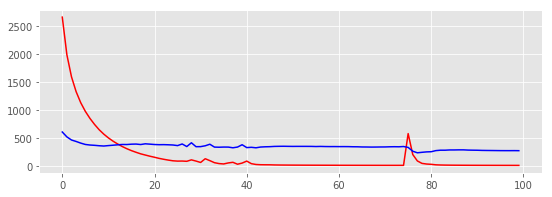

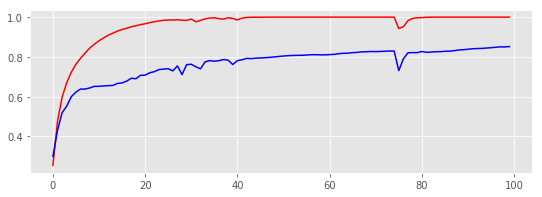

In [34]:
# cost_train
# cost_test
# acc_train
# acc_test
fig = plt.figure(figsize=(9,3))
plt.plot(cost_train, 'r-')
plt.plot(cost_test, 'b-')

# plt.axis([0,training_iterations,0,np.max(cost_history)])
plt.show()


fig = plt.figure(figsize=(9,3))
plt.plot(acc_train, 'r-')
plt.plot(acc_test, 'b-')
# plt.axis([0,training_iterations,0,np.max(cost_history)])
plt.show()

# Evaluate model

In [35]:
pred_y_list = np.zeros(0)

acc_list = []
loss_list = []

#       Performance on testing dataset:
for i in range(n_batches_test):
    if i == n_batches_test-1:
        batch_x = X_test[i * batch_size:, :, :, :]
        batch_y = Y_test[i * batch_size:, :]
    else:
        offset = (i * batch_size) % (Y_test.shape[0] - batch_size)
        batch_x = X_test[offset:(offset + batch_size), :, :, :]
        batch_y = Y_test[offset:(offset + batch_size), :]

#     logits, y_pred = session.run([logits, prediction], feed_dict={X: batch_x, Y : batch_y})
    y_pred, acc, c = session.run([prediction, accuracy, loss_func], feed_dict={X: batch_x, Y : batch_y})

    print('epoch %d - %d%% -%f) '% (i+1, (100*(i+1))//n_batches_test, acc), end='\r' if i<n_batches_test-1 else '')
#     y_pred = np.argmax(logits, axis=1)
#     pred_y_list.append(y_pred)
    pred_y_list = np.concatenate([pred_y_list, y_pred])
    
    acc_list.append(acc)
    loss_list.append(c)
#     test_acc = np.array(np.array(acc_list).mean())
#     test_loss = np.array(np.array(loss_list).sum())
    

test_acc = np.array(np.array(acc_list).mean())
test_loss = np.array(np.array(loss_list).sum())
print('Testing:\t  Loss: %2.4f \t Accuracy: %2.4f' % (test_loss/Y_test.shape[0], test_acc))

epoch 336 - 100% -0.981818) Testing:	  Loss: 0.0248 	 Accuracy: 0.8518


In [36]:
y_true = np.argmax(Y_test, 1)
y_pred =pred_y_list

In [37]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score



print('Accuracy on testing data:',sum(y_pred==y_true)/y_true.shape[0])
cf_matrix = confusion_matrix(y_true, y_pred)
print(cf_matrix)
class_wise_f1 = np.round(f1_score(y_true, y_pred, average=None)*100)*0.01
print('the mean-f1 score: {:.2f}'.format(np.mean(class_wise_f1)))

Accuracy on testing data: 0.8520649651972158
[[1017    5   30   10  100    4    3  146    4   65]
 [   0  321    1    0    3    4    0    3    1    8]
 [  18   11 1048   39   40   23    5    7   24  141]
 [   9    1   96  808   22   10    7    9   22   32]
 [   0    3   13    6 1139    0    0   54    0   11]
 [  10    6    8    9   38 1294    0   24   18   31]
 [   0    0    1    2    6    0  145    0    1    0]
 [   1    3   10    0   84    0    1 1157    1    1]
 [   5    0   36   13   17    5    1    4 1140   18]
 [  14   22  110    7   50    2    2   29   14 1112]]
the mean-f1 score: 0.86
